In [1]:
import pandas as pd
from datautils import _get_time_features,load_forecast_csv

In [2]:
#data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols,data1=load_forecast_csv("mocap",False)
data, train_slice, valid_slice, test_slice, scaler, pred_lens, data1=load_forecast_csv("phone/phone_data_20",False)

data
(7352, 20)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351],
      dtype='int64', name='date', length=7352)
(7352, 20)
data
(7352, 20)
slice(None, 4411, None)
slice(4411, 5881, None)
slice(5881, None, None)
(1, 7352, 20)


/Users/katoutsubasa/ts2vec/datautils.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)


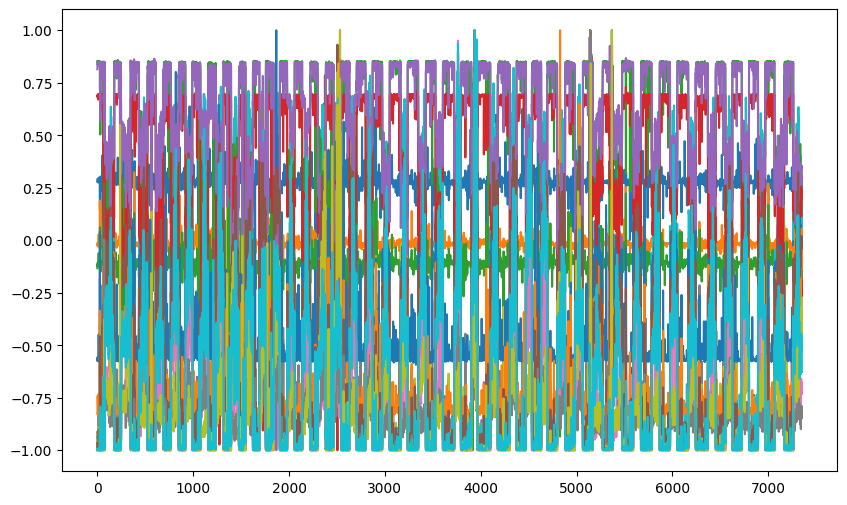

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data1)

In [4]:
!pip install tensorflow

In [5]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms = True


torch_fix_seed()

In [6]:
from ts2vec import TS2Vec
model = TS2Vec(
    input_dims=data.shape[-1],
    length_dim=275,
    device="cpu",
    output_dims=320,
    input_total=1,
    max_train_length=300,
    #output_dims=10
)

1
20


In [7]:
model.load('no_pros_k5_10.pth')

In [8]:
all_repr = model.encode(
        data,
        causal=False,
        sliding_length=1,
        sliding_padding= 200,
        batch_size=256,
        #encoding_window='multiscale'
    )

a


In [68]:
import argparse
import torch
import torch.optim as optim
import torch.nn as nn
import h5py
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

class Args:
    dataset = 'UMist'
    eta = 0.2
    epoch_rnn = 1
    batchSize = 
    learningRate = 0.01
    weightDecay = 5e-5
    momentum = 0.9
    gamma_lr = 0.0001
    power_lr = 0.75
    num_nets = 1
    epoch_pp = 20
    epoch_max = 1000
    K_s = 20
    K_c = 5
    gamma_tr = 1
    margin_tr = 0.2
    num_nsampling = 20
    use_fast = 1
    updateCNN = 1
    centralize_input = 0
    centralize_feature = 0
    normalize = 1

args = Args()


In [85]:
# Load dataset
print('==> loading data')
data_new= all_repr.reshape(all_repr.shape[1], all_repr.shape[2])[:1000]
trainData_data = torch.tensor(data_new, dtype=torch.float32)
testData_data = trainData_data.clone()

==> loading data


In [102]:
import argparse
import torch
import torch.optim as optim
import torch.nn as nn
import h5py
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

class Args:
    dataset = 'UMist'
    eta = 0.2
    epoch_rnn = 1
    batchSize = data_new.shape[0]
    learningRate = 0.01
    weightDecay = 5e-5
    momentum = 0.9
    gamma_lr = 0.0001
    power_lr = 0.75
    num_nets = 1
    epoch_pp = 5
    epoch_max = 100
    K_s = 20
    K_c = 5
    gamma_tr = 1
    margin_tr = 0.2
    num_nsampling = 20
    use_fast = 1
    updateCNN = 1
    centralize_input = 0
    centralize_feature = 0
    normalize = 1

args = Args()


In [103]:
print(trainData_data.shape)

torch.Size([1000, 320])


In [104]:
# Initialize networks parameters
def net_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Convert labels to label table
def cvt2_table_labels(labels):
    labels_sorted, indices = torch.sort(labels)
    unique_labels, inverse_indices = torch.unique(labels_sorted, return_inverse=True)
    nclasses = unique_labels.size(0)
    labels_from_one = inverse_indices + 1
    labels_tb = [[] for _ in range(nclasses)]
    for i in range(labels.size(0)):
        labels_tb[labels_from_one[i].item() - 1].append(i)
    return labels_tb

# Model definition for word embeddings
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [111]:
# Initialize networks
print(trainData_data.size(1))
input_dim = trainData_data.size(1)
num_networks = args.num_nets
network_table = []
parameters_table = []
optimizers = []
label_pre_table_table = []
label_pre_tensor_table = []
target_nclusters_table = torch.zeros(10, dtype=torch.long)
epoch_reset_labels = torch.zeros(num_networks, dtype=torch.long)

for i in range(num_networks):
    model = SimpleMLP(input_dim)  # Use the SimpleMLP model for word vectors
    model.apply(net_init)
    network_table.append(model)
    parameters_table.append(list(model.parameters()))
    optimizers.append(optim.SGD(model.parameters(), lr=args.learningRate, weight_decay=args.weightDecay, momentum=args.momentum))
    label_pre_table_table.append([])
    label_pre_tensor_table.append(torch.zeros(trainData_data.size(0), 1))


320


In [112]:
# for i in range(num_networks):
#     model = SimpleCNN()
#     model.apply(net_init)
#     network_table.append(model)
#     parameters_table.append(list(model.parameters()))
#     optimizers.append(optim.SGD(model.parameters(), lr=args.learningRate, weight_decay=args.weightDecay, momentum=args.momentum))
#     label_pre_table_table.append([])
#     label_pre_tensor_table.append(torch.zeros(trainData_data.size(0), 1))

In [113]:
# Set criterion
criterion_triplet = nn.TripletMarginLoss(margin=args.margin_tr, p=2)

In [116]:
# Extract features for images from CNN
def extract_features(model, data):
    model.eval()
    with torch.no_grad():
        features = model(data)  # .cuda() を削除
    return features

# Convert table labels to tensor labels
def cvt2_tensor_labels(labels, ind_s, ind_e):
    label_tensor = torch.zeros(ind_e - ind_s + 1, 1)
    for i, label_group in enumerate(labels):
        for j in label_group:
            label_tensor[j, 0] = i + 1
    return label_tensor

# def compute_affinity(features, k_s):
#     n_samples = features.shape[0]
#     k_s = max(1, min(k_s, n_samples - 1))

#     nbrs = NearestNeighbors(n_neighbors=k_s, algorithm='auto').fit(features)
#     distances, indices = nbrs.kneighbors(features)
    
#     # Create a square matrix of shape (n_samples, n_samples)
#     W = np.zeros((n_samples, n_samples))
    
#     # Fill the affinity matrix
#     for i in range(n_samples):
#         for j in range(k_s):
#             W[i, indices[i, j]] = np.exp(-distances[i, j] ** 2)
    
   # return distances, indices, W

# 式(3)と式(4)に基づくアフィニティ行列の計算
def compute_affinity(X, Ks, a):
    ns = X.shape[0]
    W = torch.zeros((ns, ns))
    for i in range(ns):
        distances = torch.norm(X[i] - X, dim=1)
        nearest_indices = torch.argsort(distances)[1:Ks+1]
        for j in nearest_indices:
            W[i, j] = torch.exp(-distances[j]**2 / (a * ns * Ks))
    return distances, nearest_indices, W

def update_labels(features, label_pre, target_clusters, iter):
    if features.shape[0] <= 1:
        return label_pre
    a=1
    distances, indices, W = compute_affinity(features.numpy(), args.K_s,a)
    W = csr_matrix(W)
    if iter == 0:
        print("initialize clusters...")
        n_components, labels = connected_components(csgraph=W, directed=False, return_labels=True)
        label_pre = [np.where(labels == i)[0].tolist() for i in range(n_components)]
        return label_pre
    return label_pre

def merge_labels():
    for i, model in enumerate(network_table):
        if epoch_reset_labels[i] == 0 or args.updateCNN == 0:
            features = trainData_data.float()
        else:
            features = extract_features(model, trainData_data)
        
        if args.centralize_feature == 1:
            features -= features.mean(dim=0, keepdim=True)

        if args.normalize == 1:
            features = features / features.norm(p=2, dim=1, keepdim=True)
        
        label_pre_table_table[i] = update_labels(features, label_pre_table_table[i], target_nclusters_table[i], epoch_reset_labels[i])
        epoch_reset_labels[i] += 1
        label_pre_tensor_table[i] = cvt2_tensor_labels(label_pre_table_table[i], 1, trainData_data.size(0))

def organize_samples(X, y):
    num_s = X.size(0)
    y_table = cvt2_table_labels(y)
    nclusters = len(y_table)
    
    # デバッグ: クラスタ数を出力
    print(f"Number of clusters: {nclusters}")
    
    if nclusters == 1:
        return None, None

    num_neg_sampling = args.num_nsampling
    if nclusters <= args.num_nsampling:
        num_neg_sampling = nclusters - 1

    num_triplet = 0
    for i in range(nclusters):
        if len(y_table[i]) > 1:
            num_triplet += len(y_table[i]) * (len(y_table[i]) - 1) * num_neg_sampling // 2
    
    # デバッグ: トリプレット数を出力
    print(f"Number of triplets to be generated: {num_triplet}")

    if num_triplet == 0:
        return None, None

    A = torch.zeros((num_triplet, X.size(1)), dtype=torch.float32)
    B = torch.zeros((num_triplet, X.size(1)), dtype=torch.float32)
    C = torch.zeros((num_triplet, X.size(1)), dtype=torch.float32)
    A_ind = torch.zeros(num_triplet, dtype=torch.long)
    B_ind = torch.zeros(num_triplet, dtype=torch.long)
    C_ind = torch.zeros(num_triplet, dtype=torch.long)
    id_triplet = 0

    for i in range(nclusters):
        if len(y_table[i]) > 1:
            for m in range(len(y_table[i])):
                for n in range(m + 1, len(y_table[i])):
                    is_choosed = torch.zeros(num_s, dtype=torch.int16)
                    while True:
                        id_s = torch.randint(0, num_s, (1,)).item()
                        id_t = y_table[i][m]
                        if is_choosed[id_s] == 0 and y[id_s] != y[id_t]:
                            A_ind[id_triplet] = y_table[i][m]
                            B_ind[id_triplet] = y_table[i][n]
                            C_ind[id_triplet] = id_s
                            is_choosed[id_s] = 1
                            id_triplet += 1
                        if torch.sum(is_choosed) == num_neg_sampling:
                            break

    # デバッグ: 生成されたトリプレットのインデックスを出力
    print(f"Generated triplets: {id_triplet}")

    if id_triplet == 0:
        return None, None

    A.index_copy_(0, torch.arange(num_triplet), X.index_select(0, A_ind))
    B.index_copy_(0, torch.arange(num_triplet), X.index_select(0, B_ind))
    C.index_copy_(0, torch.arange(num_triplet), X.index_select(0, C_ind))
    return [A, B, C], [A_ind, B_ind, C_ind]

# Define updateCNN function
def update_cnn():
    for model in network_table:
        model.train()
    epoch = 0
    for epoch in range(args.epoch_max):
        print(f'==> online epoch #{epoch + 1} [batchSize = {args.batchSize}] [learningRate = {args.learningRate}]')
        for batch in DataLoader(TensorDataset(trainData_data), batch_size=args.batchSize, shuffle=False):
            inputs = batch[0]
            for model, optimizer in zip(network_table, optimizers):
                optimizer.zero_grad()
                outputs = model(inputs)
                # Generate random targets for unsupervised learning
                #print("args.num_nets",args.num_nets)
                #print("inputs.size(0)",inputs.size(0))

                targets = torch.randint(0, data_new.shape[0], (inputs.size(0),))

                #print("targets",targets)
                triplets, triplets_ind = organize_samples(outputs, targets.float())
                print("triplet",triplets)
                if triplets is not None and triplets_ind is not None:
                    loss = criterion_triplet(*triplets)
                    loss.backward()
                    optimizer.step()
                    print(f'Loss: {loss.item()}')
        epoch += 1

# Evaluate performance using Silhouette Score
def evaluate_performance():
    for model in network_table:
        model.eval()
    print('==> testing')
    for labels_pre in label_pre_table_table:
        all_labels = torch.cat([torch.tensor(lbl) for lbl in labels_pre])
        unique_labels = all_labels.unique()
        if len(unique_labels) > 1 and len(unique_labels) < all_labels.size(0):  # Avoid cases where all samples are in one cluster or each sample is its own cluster
            silhouette_avg = silhouette_score(trainData_data.numpy(), all_labels.numpy())
            print(f'Silhouette Score: {silhouette_avg}')
        else:
            print(f"Skipping Silhouette Score calculation: {len(unique_labels)} unique labels")

# Check if all models are finished
def is_all_finished():
    flag = True
    print("label_pre_table_table",label_pre_table_table)
    for labels in label_pre_table_table:
        print("target_nclusters_table",target_nclusters_table)
        if len(labels) > target_nclusters_table[0]:
            flag = False
    return flag

In [117]:
# Main training loop
for n in range(args.epoch_rnn):
    for i in range(args.epoch_max):
        if i % args.epoch_pp == 0:
            merge_labels()
            evaluate_performance()
            if is_all_finished():
                break
        if args.updateCNN == 1:
            update_cnn()
    epoch_reset_labels.zero_()
    while True:
        merge_labels()
        evaluate_performance()
        if is_all_finished():
            break

==> testing
Skipping Silhouette Score calculation: 1000 unique labels
label_pre_table_table [[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 

KeyboardInterrupt: 

In [118]:
# Function to print the final clustering results
def print_final_clustering_results():
    for i, labels in enumerate(label_pre_tensor_table):
        print(f'Final clustering results for model {i + 1}:')
        print(labels)

# Print the final clustering results
print_final_clustering_results()

Final clustering results for model 1:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

In [ ]:
# Function to print the final clustering results
def print_final_clustering_results():
    for i, labels in enumerate(label_pre_tensor_table):
        print(f'Final clustering results for model {i + 1}:')
        print(labels)

# Print the final clustering results
print_final_clustering_results()